In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set()

In [0]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

db = load_iris()

Text(0, 0.5, 'petal width (cm)')

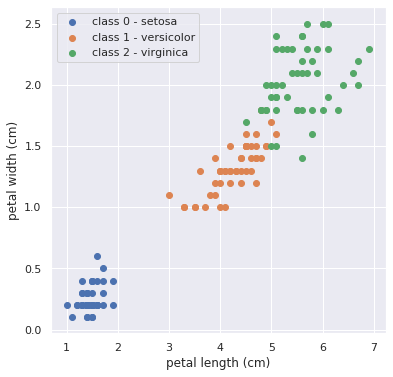

In [11]:
X = db.data[:, 2:]
y = db.target
targets = db.target_names
feat_names = db.feature_names[2:]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

for idx, target in enumerate(targets):
    ax.scatter(X[np.where(y==idx), 0], X[np.where(y==idx), 1], label=f'class {idx} - {target}')
ax.legend()
ax.set_xlabel(feat_names[0])
ax.set_ylabel(feat_names[1])

In [12]:
tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

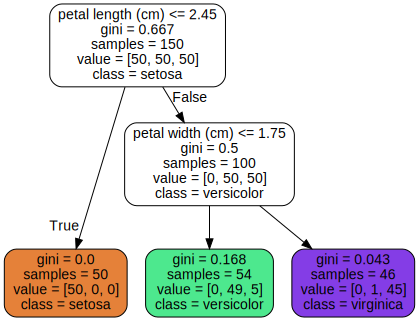

In [13]:
from sklearn.tree import export_graphviz
from graphviz import Source

graph = export_graphviz(tree_clf, feature_names=feat_names, class_names=targets, 
                        leaves_parallel=True, rounded=True, filled=True)
graph_source = Source(graph)
graph_source

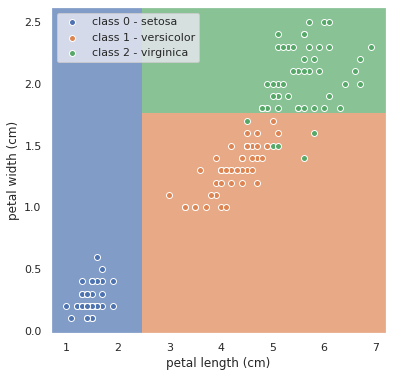

In [14]:
from matplotlib.colors import ListedColormap

def draw_clf(model, X, y, meshgrid_steps=100, meshgrid_padding=0.05, fig_size=(6, 6), c_lightering=0.3, 
             feature_names=None, target_names=None, raw_data=False):

    x0_min, x0_max = np.min(X[:, 0]), np.max(X[:, 0])
    x1_min, x1_max = np.min(X[:, 1]), np.max(X[:, 1])

    x0_delta = (x0_max - x0_min) * meshgrid_padding
    x1_delta = (x1_max - x1_min) * meshgrid_padding

    x0_values = np.linspace(x0_min - x0_delta, x0_max + x0_delta, meshgrid_steps);
    x1_values = np.linspace(x1_min - x1_delta, x1_max + x1_delta, meshgrid_steps);

    xx0, xx1 = np.meshgrid(x0_values, x1_values)
    z = model.predict(np.c_[xx0.ravel(), xx1.ravel()])
    z = z.reshape(xx0.shape)

    current_palette = np.array(sns.color_palette()[:len(np.unique(y))])
    lighter_pallete = ListedColormap(current_palette + (1 - current_palette) * c_lightering)

    if raw_data:
        return xx0, xx1, z, lighter_pallete

    fig, ax = plt.subplots(1, 1, figsize=fig_size)
    ax.pcolormesh(xx0, xx1, z, cmap=lighter_pallete)

    labels = [f'class {x} - {target_names[x]}' if isinstance(target_names, (np.ndarray, list)) else f'class {x}' 
              for x in range(len(np.unique(y)))]

    for idx, lbl in enumerate(labels):
        ax.scatter(X[np.where(y==idx), 0], X[np.where(y==idx), 1], label=lbl, ec='w')
        ax.legend()

    ax.set_xlabel(feature_names[0] if feature_names else 'x0')
    ax.set_ylabel(feature_names[1] if feature_names else 'x1')

    return

draw_clf(tree_clf, X, y, feature_names=feat_names, target_names=targets);

# Gini Impurity vs Entropy
---
Gini Impurity:
<br>
$G_i = 1 - \sum_{k=1}^{n}p_{i,k}^2$, <br>
- $p_{i,k}$ is the ratio of class k instances among the training instances in the i-th node

<br>
Example (2nd depth-level, class versicolor):

$G_i = 1 – (\frac{0}{54})^2 – (\frac{49}{54})^2 – (\frac{5}{54})^2 ≈ 0.168$

---

Entropy:
<br>
$H_i = - \sum_{k=1}^{n}p_{i,k}log(p_{i,k})$ 
- $p_{i,k} \neq  0$

<br>
Example (2nd depth-level, class versicolor):

$H_i =  – \frac{49}{54}log(\frac{49}{54}) – \frac{5}{54}log(\frac{5}{54}) ≈ 0.31$

-------- entropy -------
f1 score - train set: 0.9612403100775194
f1 score - test set: 0.9380530973451328

-------- gini -------
f1 score - train set: 0.9620253164556962
f1 score - test set: 0.9391304347826086



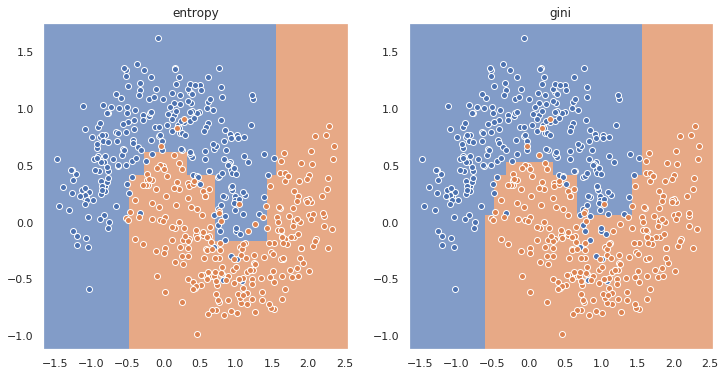

In [15]:
from sklearn.datasets import make_moons
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split


X, y = make_moons(n_samples=500, noise=0.25)

criterions = {'gini', 'entropy'}
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for criterion, ax in zip(criterions, axes):
    x0 = X[:, 0]
    x1 = X[:, 1]

    tree_clf = DecisionTreeClassifier(max_depth=5, criterion=criterion)
    tree_clf.fit(X_train, y_train)
    y_train_pred = tree_clf.predict(X_train)
    y_test_pred = tree_clf.predict(X_test)

    xx0, xx1, z, color_palete = draw_clf(tree_clf, X, y, raw_data=True)
    ax.pcolormesh(xx0, xx1, z, cmap=color_palete)
    ax.scatter(x0[np.where(y==0)], x1[np.where(y==0)], ec='w')
    ax.scatter(x0[np.where(y==1)], x1[np.where(y==1)], ec='w')
    ax.set_title(criterion)

    print(f'-------- {criterion} -------')
    print(f'f1 score - train set: {f1_score(y_train, y_train_pred)}')
    print(f'f1 score - test set: {f1_score(y_test, y_test_pred)}')
    print()

# Regularization Hyperparameters

Available hyperparameters:
- <b>max_depth</b> - the maximum depth of the tree
- <b>min_samples_split</b> - the minimum number of samples a node must have before it can be split
- <b>min_samples_leaf</b> - the minimum numer of samples a leaf node must have
- <b>min_weight_fraction_leaf</b> - same as *min_samples_leaf* but expressed as a fraction of the total number of weighted instances
- <b>max_leaf_nodes</b> - maximum number of leaf nodes
- <b>max_features</b> - maximum number of features that are evaluated for splitting at each node


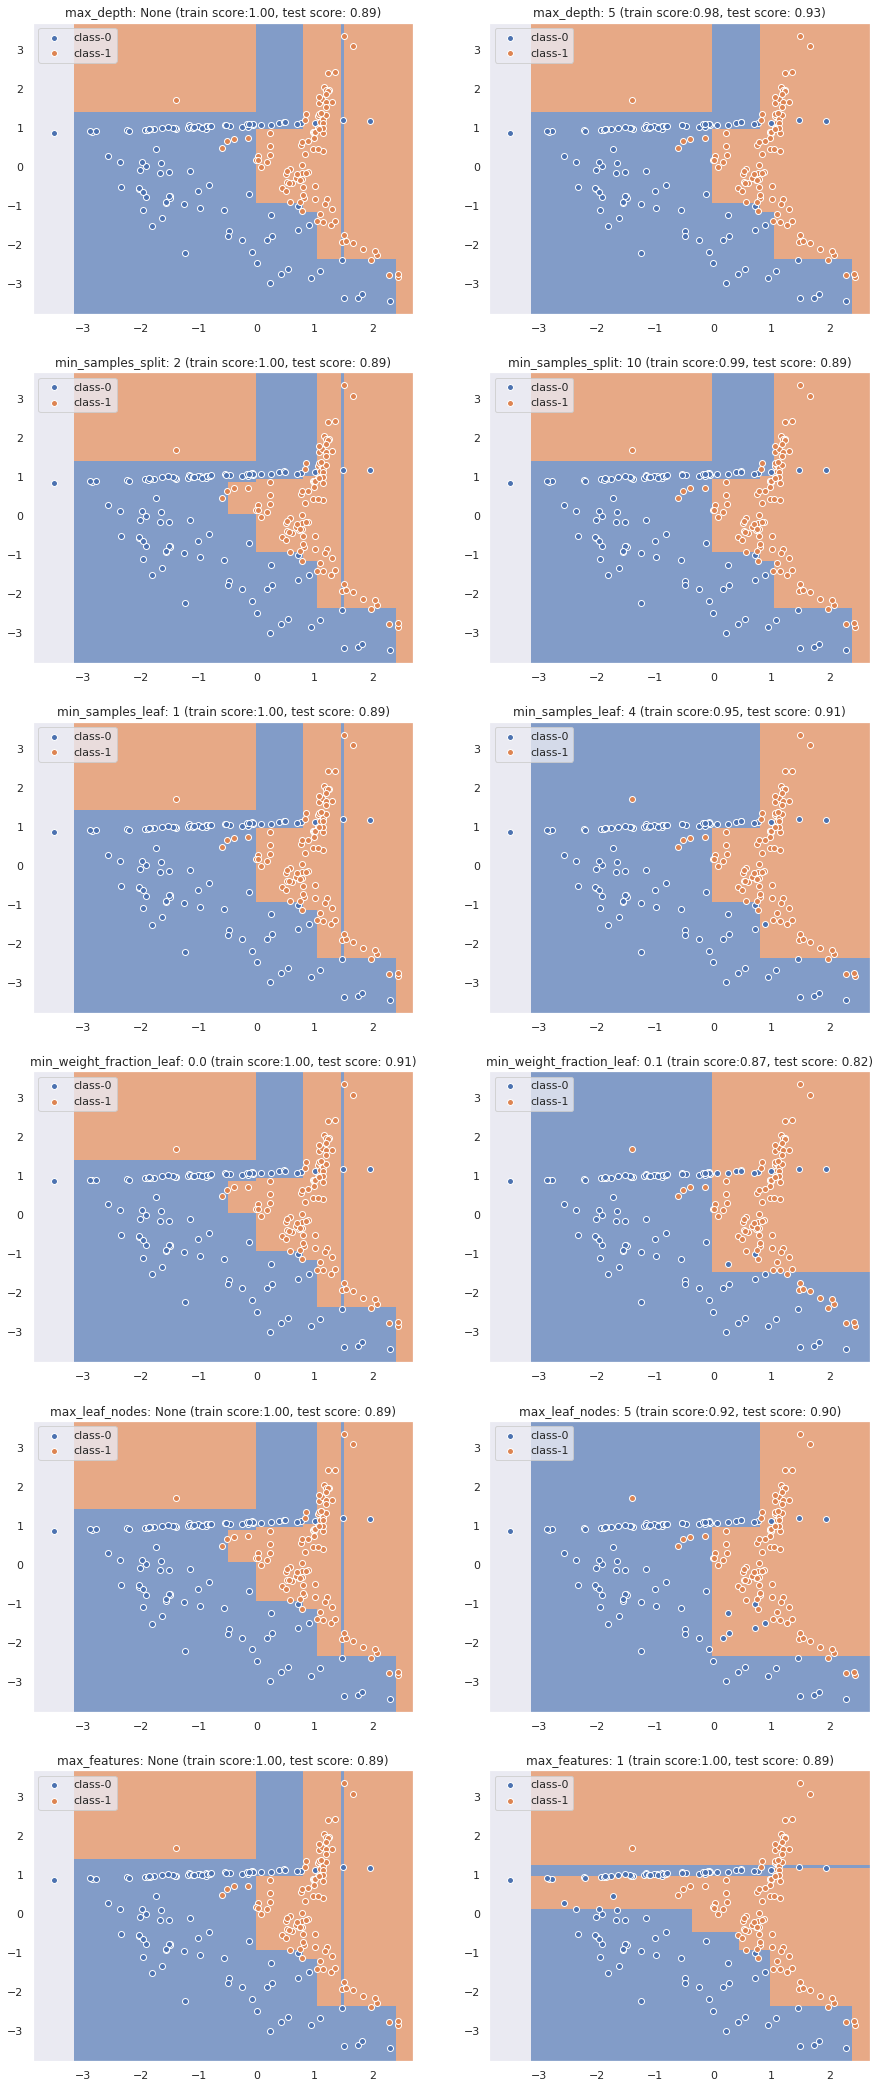

In [17]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=200, n_features=2, n_redundant=0, n_informative=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

x0 = X[:, 0]
x1 = X[:, 1]
class_idx = [np.where(y==ii) for ii in np.unique(y)]

params = {
    'max_depth': [None, 5],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4],
    'min_weight_fraction_leaf': [0.0, 0.1],
    'max_leaf_nodes': [None, 5],
    'max_features': [None, 1]
}

fig, axes = plt.subplots(nrows=len(params), ncols=2, figsize=(15, 37.5))

for param, ax in zip(params.items(), axes):
    param_name = param[0]
    param_values = param[1]
    for j, p_val in enumerate(param_values):
        tmp_params = {param_name: p_val}

        tree_clf = DecisionTreeClassifier(**tmp_params)
        tree_clf.fit(X_train, y_train)
        
        y_train_pred = tree_clf.predict(X_train)
        y_test_pred = tree_clf.predict(X_test)
        
        f1_train = f1_score(y_train, y_train_pred)
        f1_test = f1_score(y_test, y_test_pred)

        xx0, xx1, z, color_palete = draw_clf(tree_clf, X_train, y_train, raw_data=True)
        ax[j].pcolormesh(xx0, xx1, z, cmap=color_palete)

        for i_class in np.unique(y):
            ax[j].scatter(x0[np.where(y==i_class)], x1[np.where(y==i_class)], label=f'class-{i_class}', ec='w')
        ax[j].set_title(f'{param_name}: {p_val} (train score:{f1_train:.2f}, test score: {f1_test:.2f})')
        ax[j].legend()